# Predict the stock movement

## 大綱
* 預測目標
* 套件
* 預處理
* 訓練
    * Logistic Regression
    * NN
    * Decision tree
* 驗證與結果
* 討論

## 預測目標
* 根據四天的交易日的收盤價漲跌與成交量下降和增加，來預測第五天的股票收盤價是漲還是跌。

## 套件
* PyTorch : version 1.3.0
* numpy
* matplotlib
* pandas
* scikit-learn

In [1]:
# 匯入 PyTorch 套件
# 在 python 中的介面名稱為 torch
import torch
from torch import tensor
from torch import nn
from torch import sigmoid
import torch.nn.functional as F
import torch.optim as optim
# 匯入 numpy, matplotlib, pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/home/arielwu/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 預處理
* 沒有缺失資料
* Open Price, Close Price, High Price, Low Price 成長趨勢相似，所以我只選擇一種當輸入參數--Close Price
* 成交量也當作數入參數
* 因為數字的浮動變化太大，且預測目標為以後的股票漲跌趨勢，所以我認為要用相對於基準點的漲跌當作數入參數。
    * 漲與增加: 1 跌與減少: 0
    * close_one:   相對於一天的 Close Price
    * close_two:   相對於兩天的 Close Price
    * close_three: 相對於三天的 Close Price
    * close_four:  相對於四天的 Close Price
    * volume_one:  相對於一天的 Volume Price
    * volume_two:  相對於兩天的 Volume Price
    * volume_three:相對於三天的 Volume Price
    * volume_four: 相對於四天的 Volume Price
* 輸出參數: 五天後的漲跌--outcome

In [2]:
train_df = pd.read_csv('stock_train.csv') # 讀取訓練資料
train_df.describe()
# 可知道沒有缺失資料

,Open Price,Close Price,High Price,Low Price,Volume
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,1656.142686,1656.767562,1664.427054,1647.425128,2.948755e+09
std,485.292193,485.226120,484.808706,485.576116,1.351675e+09
min,679.280000,676.530000,695.270000,666.790000,5.181584e+08
25%,1238.602500,1239.337500,1246.695000,1227.587500,2.048980e+09
50%,1649.135000,1650.405000,1656.145000,1639.600000,2.506637e+09
75%,2070.300000,2071.190000,2079.507500,2058.757500,3.373334e+09
max,2692.710000,2690.160000,2694.970000,2685.920000,9.120100e+09


In [3]:
test_df = pd.read_csv('stock_test.csv')
test_df.describe()
# 可知道沒有缺失資料

,Open Price,Close Price,High Price,Low Price,Volume
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,2747.910397,2746.030873,2762.747778,2730.143929,2.154050e+09
std,99.017479,100.251272,92.991345,106.490954,4.538626e+08
min,2363.120000,2351.100000,2410.340000,2346.580000,9.516523e+08
25%,2689.465000,2690.512500,2705.847500,2663.677500,1.879841e+09
50%,2742.170000,2741.920000,2755.575000,2725.290000,2.063820e+09
75%,2811.430000,2814.322500,2824.802500,2800.630000,2.341078e+09
max,2936.760000,2930.750000,2940.910000,2927.110000,4.560164e+09


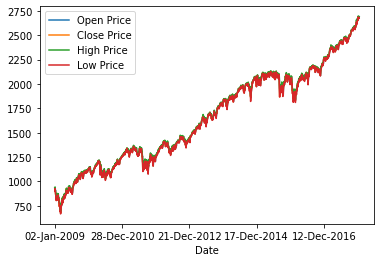

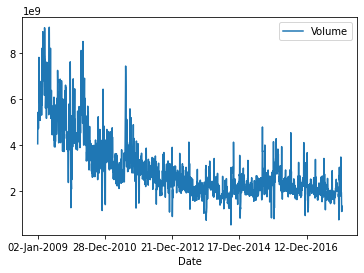

In [4]:
ax=train_df.plot('Date','Open Price')
ax=train_df.plot('Date','Close Price',ax=ax)
ax=train_df.plot('Date','High Price',ax=ax)
train_df.plot('Date','Low Price',ax=ax)
train_df.plot('Date','Volume')

In [5]:
# train dataset
train_x = pd.DataFrame(np.zeros(18072).reshape((2259,8)),columns=['close_one','close_two','close_three','close_four','volume_one','volume_two','volume_three','volume_four'])
train_y = pd.DataFrame(np.zeros(2259).reshape((2259,1)),columns=['close_five'])
for i in range(0,len(train_df)-5):
    a = 1 if (train_df.iloc[i,2]<train_df.iloc[i+1, 2]) else 0
    b = 1 if (train_df.iloc[i,2]<train_df.iloc[i+2, 2]) else 0
    c = 1 if (train_df.iloc[i,2]<train_df.iloc[i+3, 2]) else 0
    d = 1 if (train_df.iloc[i,2]<train_df.iloc[i+4, 2]) else 0
    A = 1 if (train_df.iloc[i,5]<train_df.iloc[i+1, 5]) else 0
    B = 1 if (train_df.iloc[i,5]<train_df.iloc[i+2, 5]) else 0
    C = 1 if (train_df.iloc[i,5]<train_df.iloc[i+3, 5]) else 0
    D = 1 if (train_df.iloc[i,5]<train_df.iloc[i+4, 5]) else 0
    E = 1 if (train_df.iloc[i,2]<train_df.iloc[i+5, 2]) else 0
    train_x.iloc[i] = [a,b,c,d,A,B,C,D]
    train_y.iloc[i] = [E]
train_x = torch.from_numpy(train_x.values)
train_y = torch.from_numpy(train_y.values)

In [6]:
# test dataset
test_x = pd.DataFrame(np.zeros(1976).reshape((247,8)),columns=['close_one','close_two','close_three','close_four','volume_one','volume_two','volume_three','volume_four'])
test_y = pd.DataFrame(np.zeros(247).reshape((247,1)),columns=['close_five'])
for i in range(0,len(test_df)-5):
    a = 1 if (test_df.iloc[i,2]<test_df.iloc[i+1, 2]) else 0
    b = 1 if (test_df.iloc[i,2]<test_df.iloc[i+2, 2]) else 0
    c = 1 if (test_df.iloc[i,2]<test_df.iloc[i+3, 2]) else 0
    d = 1 if (test_df.iloc[i,2]<test_df.iloc[i+4, 2]) else 0
    A = 1 if (test_df.iloc[i,5]<test_df.iloc[i+1, 5]) else 0
    B = 1 if (test_df.iloc[i,5]<test_df.iloc[i+2, 5]) else 0
    C = 1 if (test_df.iloc[i,5]<test_df.iloc[i+3, 5]) else 0
    D = 1 if (test_df.iloc[i,5]<test_df.iloc[i+4, 5]) else 0
    E = 1 if (test_df.iloc[i,2]<test_df.iloc[i+5, 2]) else 0
    test_x.iloc[i] = [a,b,c,d,A,B,C,D]
    test_y.iloc[i] = [E]
test_x = torch.from_numpy(test_x.values)
test_y = torch.from_numpy(test_y.values)

## Logistic Regression
* epoch 數: 100 次
* batch_size : 100 
* Model
    * linear
    * sigmoid
    * loss : BCELoss
    * optimizer : SGD
* 預測
    * 若預測值大於 0.5，則判斷為漲：小於 0.5，則判斷為跌。
    * 最後結果：準確率有 8 成
    

In [7]:
# 驗證

batch_size = 100                         # 設定每次抽樣的數量
n_epoch = 60                              # 設定資料集總訓練次數

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader # 匯入資料集抽樣工具

class Logistic(nn.Module):
    def __init__(self):
        super(Logistic, self).__init__()
        self.linear = nn.Linear(8,1)
        
    def forward(self, x):
        pred_y = sigmoid(self.linear(x))
        return pred_y

## train data
train_dataset = TensorDataset(train_x,train_y)
train_data_loader = DataLoader(            # 創造 DataLoader 實例
    train_dataset,                         # 對資料集 train_dataset 進行抽樣
    batch_size=batch_size,                 # 設定每次抽樣的數量
    shuffle=True,                          # 設定隨機抽樣
)
## test data
test_dataset = TensorDataset(test_x,test_y)
test_data_loader = DataLoader(          # 創造 DataLoader 實例
    test_dataset,                       # 對資料集 test_dataset 進行抽樣
    batch_size=batch_size,              # 設定每次抽樣的數量
    shuffle=True,                       # 設定隨機抽樣
)
    
logistic = Logistic()
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.SGD(logistic.parameters(),lr=0.0001)
total = train_x.size()[0]               # 共有多少筆訓練資料:2259筆

for epoch in range(n_epoch):            # 總共訓練 n_epoch 次
    for batch_x, batch_y in train_data_loader:
        
        pred_y = logistic(batch_x.float())         # 自動呼叫 forward 計算 batch_x 得到 pred_y
        loss = criterion(pred_y,        # 計算 pred_y 與 batch_y 的均方誤差
                         batch_y.float())
        
        loss.backward()                 # 使用向後傳播計算梯度
        optimizer.step()                # 使用梯度下降更新模型參數
    
    with torch.no_grad():               # 此區塊不會計算梯度
        total_loss = 0                  # 統計訓練資料誤差
        total_acc = 0                   # 統計準確個數
        for batch_x, batch_y in train_data_loader:
            
            pred_y = logistic(batch_x.float())
            loss = criterion(pred_y, batch_y.float())
            
            total_loss += float(loss) / len(train_data_loader)
            mask=(pred_y>0.5)
            correct=(mask==batch_y)
            total_acc+=correct[correct==True].size()[0]
        
        print('Epoch {}, training loss: {}, accurracy: {}'.format(epoch, total_loss, total_acc/total))
        

Epoch 0, training loss: 0.7168531003205674, accurracy: 0.43249225320938467
Epoch 1, training loss: 0.7064408608104871, accurracy: 0.47808764940239046
Epoch 2, training loss: 0.6910846751669179, accurracy: 0.4997786631252767
Epoch 3, training loss: 0.6727349084356556, accurracy: 0.6201859229747676
Epoch 4, training loss: 0.6521001898724099, accurracy: 0.6131031429836211
Epoch 5, training loss: 0.6324184122292891, accurracy: 0.6100044267374944
Epoch 6, training loss: 0.6148104512173196, accurracy: 0.6042496679946879
Epoch 7, training loss: 0.5996798328731371, accurracy: 0.6033643204957946
Epoch 8, training loss: 0.5888978657515151, accurracy: 0.6024789729969012
Epoch 9, training loss: 0.5787832957247029, accurracy: 0.6024789729969012
Epoch 10, training loss: 0.5694913630900175, accurracy: 0.6024789729969012
Epoch 11, training loss: 0.561777827532395, accurracy: 0.617087206728641
Epoch 12, training loss: 0.5513678944629172, accurracy: 0.6281540504648074
Epoch 13, training loss: 0.54369077

In [8]:
# 儲存 & 載入模型

# torch.save(logistic.state_dict(), './data/logistic.ckpt')    # 儲存模型參數
logistic.load_state_dict(torch.load('./data/logistic.ckpt')) # 載入模型參數

<All keys matched successfully>

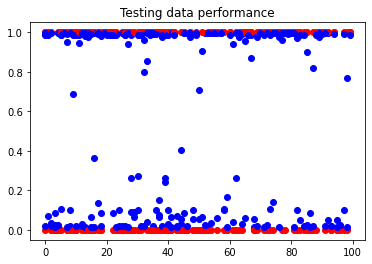

 testing accurracy: 0.8906882591093117


In [9]:
total_acc = 0                   # 統計準確個數
total_test = test_x.size()[0]   # 共有多少筆訓練資料

with torch.no_grad():
    for batch_x, batch_y in test_data_loader:

        pred_y = logistic(batch_x.float())

        mask=(pred_y>0.5)
        correct=(mask==batch_y)
        total_acc+=correct[correct==True].size()[0]
        plt.scatter(np.arange(batch_y.size()[0]), batch_y, color='red') # 畫出訓練資料答案分佈
        plt.scatter(np.arange(pred_y.size()[0]), pred_y, color='blue') # 畫出訓練資料預測分佈

    plt.title('Testing data performance')
    plt.show()

    print(' testing accurracy: {}'.format(total_acc/total_test))

## Neural Network
* epoch 數: 60 次
* batch_size : 100 
* Model
    * linear
    * sigmoid
    * loss : MSELoss
    * optimizer : SGD
* 預測

In [10]:
# 建立模型
import torch.nn as nn                   # 匯入神經網路模型
import torch.nn.functional as F         # 匯入激發函數

class MyModel(nn.Module):               # 模型需要繼承自 nn.Module
    def __init__(self,                  # 定義模型結構
                 in_dim,                # 定義輸入層維度
                 hid_dim,               # 定義隱藏層維度
                 out_dim):              # 定義輸出層維度

        super(MyModel, self).__init__() # 繼承 nn.Module 所有屬性
        
        self.layer1 = nn.Linear(        # 創造線性層 self.layer1
            in_features=in_dim,         # 設定線性層輸入維度
            out_features=hid_dim        # 設定線性層輸出維度
        )
        self.layer2 = nn.Linear(        # 創造線性層 self.layer2
            in_features=hid_dim,        # 設定線性層輸入維度
            out_features=out_dim        # 設定線性層輸出維度
        )
        
    def forward(self, batch_x):         # 定義運算流程
        h = self.layer1(batch_x)        # 使用線性層 self.layer1 輸入 batch_x 計算得到 h
        a = F.relu(h)                   # 使用 ReLU 激發函數輸入 h 得到 a
        y = self.layer2(a)              # 使用線性層 self.layer2 輸入 a 計算得到 y
        return y                        # 輸出 y
    
# 訓練
batch_size = 100                        # 設定每次抽樣的數量
n_epoch = 60                           # 設定資料集總訓練次數
hid_dim = 10                            # 設定隱藏層維度

model = MyModel(                        # 創造 MyModel 模型實例
    in_dim=8,                           # 設定輸入層維度
    hid_dim=hid_dim,                    # 設定隱藏層維度
    out_dim=1                           # 設定輸出層維度
)

criterion = nn.MSELoss()                # 創造均方誤差計算工具

optimizer = optim.SGD(                        # 創造計算隨機梯度下降的工具
    model.parameters(),                 # 設定計算梯度下降的目標
    lr=0.0001                           # 設定學習率
)

total = train_x.size()[0]               # 共有多少筆訓練資料:2259筆

for epoch in range(n_epoch):            # 總共訓練 n_epoch 次
    for batch_x, batch_y in train_data_loader:
        
        pred_y = model(batch_x.float())         # 自動呼叫 forward 計算 batch_x 得到 pred_y
        loss = criterion(pred_y,        # 計算 pred_y 與 batch_y 的均方誤差
                         batch_y.float())
        
        loss.backward()                 # 使用向後傳播計算梯度
        optimizer.step()                # 使用梯度下降更新模型參數
    
    with torch.no_grad():               # 此區塊不會計算梯度
        total_loss = 0                  # 統計訓練資料誤差
        total_acc = 0                   # 統計準確個數
        for batch_x, batch_y in train_data_loader:
            
            pred_y = model(batch_x.float())
            loss = criterion(pred_y, batch_y.float())
            
            total_loss += float(loss) / len(train_data_loader)
            mask=(pred_y>0.5)
            correct=(mask==batch_y)
            total_acc+=correct[correct==True].size()[0]
            
        print('Epoch {}, training loss: {}, accurracy: {}'.format(epoch, total_loss, total_acc/total))
    

Epoch 0, training loss: 0.5072068831195002, accurracy: 0.4019477644975653
Epoch 1, training loss: 0.35283919650575396, accurracy: 0.4019477644975653
Epoch 2, training loss: 0.2204976114241973, accurracy: 0.6927844178840195
Epoch 3, training loss: 0.21947243032248123, accurracy: 0.6414342629482072
Epoch 4, training loss: 0.3601100341133449, accurracy: 0.5980522355024347
Epoch 5, training loss: 0.4823257067929144, accurracy: 0.5980522355024347
Epoch 6, training loss: 0.42405786203301465, accurracy: 0.5980522355024347
Epoch 7, training loss: 0.27501729130744934, accurracy: 0.6077910579902612
Epoch 8, training loss: 0.20753588883773139, accurracy: 0.6308100929614874
Epoch 9, training loss: 0.23230413703814803, accurracy: 0.5635236830455954
Epoch 10, training loss: 0.29153769301331556, accurracy: 0.40903054448871184
Epoch 11, training loss: 0.3436338227728139, accurracy: 0.4019477644975653
Epoch 12, training loss: 0.34823399393454835, accurracy: 0.4019477644975653
Epoch 13, training loss: 0

In [11]:
# 儲存 & 載入模型

# torch.save(model.state_dict(), './data/model.ckpt')    # 儲存模型參數
model.load_state_dict(torch.load('./data/model.ckpt')) # 載入模型參數

<All keys matched successfully>

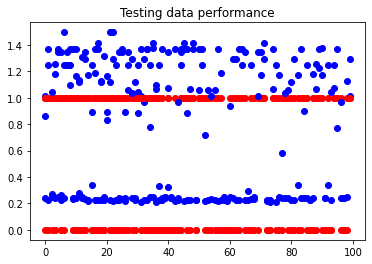

 testing accurracy: 0.8987854251012146


In [12]:
total_acc = 0                   # 統計準確個數
total_test = test_x.size()[0]   # 共有多少筆訓練資料

with torch.no_grad():
    for batch_x, batch_y in test_data_loader:

        pred_y = model(batch_x.float())

        mask=(pred_y>0.5)
        correct=(mask==batch_y)
        total_acc+=correct[correct==True].size()[0]
        plt.scatter(np.arange(batch_y.size()[0]), batch_y, color='red') # 畫出訓練資料答案分佈
        plt.scatter(np.arange(pred_y.size()[0]), pred_y, color='blue') # 畫出訓練資料預測分佈

    plt.title('Testing data performance')
    plt.show()

    print(' testing accurracy: {}'.format(total_acc/total_test))

## 決策樹

In [13]:
from sklearn.tree import DecisionTreeClassifier   # 匯入決策樹模型
from sklearn.metrics import accuracy_score        # 匯入準確度計算工具

tree = DecisionTreeClassifier(random_state=1012) # 創造決策樹模型
tree.fit(train_x, train_y)                       # 訓練決策樹模型

pred_y = tree.predict(train_x)                   # 確認模型是否訓練成功
acc = accuracy_score(train_y, pred_y)             # 計算準確度

print('training accuracy: {}'.format(acc))                 # 輸出準確度

pred_y = tree.predict(test_x)                   # 確認模型是否訓練成功
acc = accuracy_score(test_y, pred_y)             # 計算準確度

print('testing accuracy: {}'.format(acc))                 # 輸出準確度

training accuracy: 0.8543603364320496
testing accuracy: 0.8785425101214575


## 討論
* nn model 有較高的 accuracy，但 LR model 也很接近，我認為是因為訓練和測試資料的整梯趨勢是往上增長的，若相鄰的天數大多是漲，則預測目標有有很大的機率會預測準確（預測漲）。
* 有可能 dataset 不一樣會造成結果不同，如果依照我訓練模型的情況，若四天中一下漲一下跌，很優可能會誤判。
* 一開始我只丟一天的冊資，發現結果不佳（約五十幾趴），後來丟多天的input，accurracy 有上升。
* sigmoid 的加入也能提升 accurracy。